# Deeper Neural Networks with nn.ModuleList(): Multi-Class Spiral Classification

In [1]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting and visualization
import numpy as np  # Import numpy for numerical operations
import torch  # Import PyTorch for neural network operations
import torch.nn as nn  # Import neural network modules from PyTorch
import torch.nn.functional as F  # Import functional interface for neural network operations
from matplotlib.colors import ListedColormap  # Import colormap for visualization
from torch.utils.data import Dataset, DataLoader  # Import data handling utilities

torch.manual_seed(42)  # Ensure reproducible results across experiments

# GPU/CPU device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device for computation
print(f"Using device: {device}")  # Display selected device
if device.type == 'cuda':  # If using GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # Display GPU name
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")  # Display GPU memory

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 4.0 GB


In [2]:
# =============================================================================
# Visualization Functions for Multi-Class Classification
# =============================================================================

def plot_decision_regions_3class(model, data_set, device=device):  # Function to visualize decision boundaries
    """Plot decision regions for 3-class classification problems"""
    
    # Define colormaps for visualization
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])  # Light colors for regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])  # Bold colors for data points
    
    # Extract data and convert to numpy for plotting
    X = data_set.x.cpu().numpy()  # Move to CPU for numpy conversion
    y = data_set.y.cpu().numpy()  # Move to CPU for numpy conversion
    
    # Set up mesh grid for decision boundary visualization
    h = 0.02  # Step size in mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # X-axis bounds
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # Y-axis bounds
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Create mesh grid
    
    # Create tensor for prediction and move to appropriate device
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).to(device)  # Flatten and move to device
    
    # Make predictions across the mesh grid
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        _, yhat = torch.max(model(XX), 1)  # Get predictions
    
    yhat = yhat.cpu().numpy().reshape(xx.shape)  # Move to CPU and reshape
    
    # Plot decision regions and data points
    plt.figure(figsize=(10, 8))  # Set figure size
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, alpha=0.8)  # Plot decision regions
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', markersize=8, label='Class 0')  # Plot class 0
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', markersize=8, label='Class 1')  # Plot class 1
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'bo', markersize=8, label='Class 2')  # Plot class 2
    plt.title("Decision Regions for 3-Class Spiral Dataset", fontsize=14)  # Add title
    plt.xlabel("Feature 1", fontsize=12)  # X-axis label
    plt.ylabel("Feature 2", fontsize=12)  # Y-axis label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, alpha=0.3)  # Add grid
    plt.show()  # Display plot

In [3]:
# =============================================================================
# Spiral Dataset Class for Multi-Class Classification
# =============================================================================

class SpiralData(Dataset):  # Custom dataset class for spiral data
    """Generate spiral dataset for 3-class classification"""
    
    def __init__(self, K=3, N=500):  # Constructor with number of classes and samples per class
        """
        Create spiral dataset with K classes and N samples per class
        Modified from: http://cs231n.github.io/neural-networks-case-study/
        """
        D = 2  # Number of dimensions (2D spiral)
        X = np.zeros((N * K, D))  # Initialize data matrix
        y = np.zeros(N * K, dtype='uint8')  # Initialize class labels
        
        # Generate spiral data for each class
        for j in range(K):  # Loop through each class
            ix = range(N * j, N * (j + 1))  # Index range for current class
            r = np.linspace(0.0, 1, N)  # Radius values from 0 to 1
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # Theta with noise
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]  # Convert to Cartesian coordinates
            y[ix] = j  # Set class labels
        
        # Convert to PyTorch tensors
        self.y = torch.from_numpy(y).type(torch.LongTensor)  # Labels as long tensor
        self.x = torch.from_numpy(X).type(torch.FloatTensor)  # Features as float tensor
        self.len = y.shape[0]  # Store dataset length
        self.K = K  # Store number of classes
        self.N = N  # Store samples per class
    
    def __getitem__(self, index):  # Get single sample
        """Return feature-label pair for given index"""
        return self.x[index], self.y[index]  # Return data point
    
    def __len__(self):  # Get dataset length
        """Return total number of samples"""
        return self.len  # Return dataset size
    
    def plot_data(self):  # Visualize the dataset
        """Plot the spiral dataset with different colors for each class"""
        plt.figure(figsize=(10, 8))  # Set figure size
        
        # Plot each class with different colors and markers
        colors = ['red', 'green', 'blue']  # Colors for each class
        markers = ['o', 's', '^']  # Different markers for each class
        
        for class_idx in range(self.K):  # Loop through classes
            mask = self.y == class_idx  # Create mask for current class
            plt.scatter(self.x[mask, 0].numpy(), self.x[mask, 1].numpy(),  # Plot data points
                       c=colors[class_idx], marker=markers[class_idx], s=50,
                       label=f'Class {class_idx}', alpha=0.7)
        
        plt.title("3-Class Spiral Dataset", fontsize=14)  # Add title
        plt.xlabel("Feature 1", fontsize=12)  # X-axis label
        plt.ylabel("Feature 2", fontsize=12)  # Y-axis label
        plt.legend(fontsize=12)  # Add legend
        plt.grid(True, alpha=0.3)  # Add grid
        plt.axis('equal')  # Equal aspect ratio
        plt.show()  # Display plot

In [4]:
# =============================================================================
# Deep Neural Network with nn.ModuleList() (GPU-Enabled)
# =============================================================================

class DeepNetModuleList(nn.Module):  # Deep neural network using ModuleList
    """Deep neural network implemented with nn.ModuleList for flexible architecture"""
    
    def __init__(self, layers):  # Constructor with layer configuration
        """
        Initialize deep network with specified layer sizes
        Args:
            layers: List of integers representing layer sizes [input, hidden1, hidden2, ..., output]
        """
        super(DeepNetModuleList, self).__init__()  # Initialize parent class
        
        self.hidden = nn.ModuleList()  # Create ModuleList for layers
        
        # Create linear layers based on layer specification
        for input_size, output_size in zip(layers, layers[1:]):  # Iterate through consecutive layer pairs
            self.hidden.append(nn.Linear(input_size, output_size))  # Add linear transformation
        
        self.num_layers = len(self.hidden)  # Store number of layers
        self.layers_config = layers  # Store layer configuration
    
    def forward(self, x):  # Forward pass through network
        """Forward pass with ReLU activation for hidden layers"""
        activation = x  # Initialize with input
        
        # Apply transformations layer by layer
        for layer_idx, linear_transform in enumerate(self.hidden):  # Iterate through layers
            if layer_idx < self.num_layers - 1:  # For all layers except the last
                activation = F.relu(linear_transform(activation))  # Apply ReLU activation
            else:  # For the output layer
                activation = linear_transform(activation)  # No activation (logits for classification)
        
        return activation  # Return final output
    
    def get_architecture_info(self):  # Method to display architecture information
        """Display network architecture details"""
        print(f"Network Architecture: {' -> '.join(map(str, self.layers_config))}")
        print(f"Total layers: {self.num_layers}")
        
        total_params = sum(p.numel() for p in self.parameters())  # Calculate total parameters
        print(f"Total parameters: {total_params:,}")
        
        # Display layer-wise parameter count
        for i, layer in enumerate(self.hidden):  # Iterate through layers
            layer_params = sum(p.numel() for p in layer.parameters())  # Count layer parameters
            print(f"  Layer {i+1}: {layer_params:,} parameters")

In [5]:
# =============================================================================
# Enhanced Training Function with GPU Support and Advanced Metrics
# =============================================================================

def train_deep_modulelist(data_set, model, criterion, train_loader, optimizer, epochs=100, device=device):  # Training function with enhanced tracking
    """
    Train deep neural network with comprehensive performance tracking
    Returns loss history, accuracy history, and training metrics
    """
    
    # Move model to device
    model = model.to(device)  # Transfer model to GPU/CPU
    criterion = criterion.to(device)  # Transfer criterion to device
    
    # Initialize tracking lists
    LOSS = []  # Track training loss per batch
    ACC = []   # Track accuracy per epoch
    EPOCH_LOSS = []  # Track average loss per epoch
    
    print(f"Training model on {device} for {epochs} epochs...")  # Progress indicator
    
    model.train()  # Set model to training mode
    
    for epoch in range(epochs):  # Loop through epochs
        epoch_loss = 0.0  # Initialize epoch loss
        num_batches = 0  # Count batches per epoch
        
        for batch_x, batch_y in train_loader:  # Process training batches
            # Move data to device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # Transfer to GPU/CPU
            
            optimizer.zero_grad()  # Clear gradients
            yhat = model(batch_x)  # Forward pass
            loss = criterion(yhat, batch_y)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            
            # Track loss
            batch_loss = loss.item()  # Get scalar loss value
            LOSS.append(batch_loss)  # Store batch loss
            epoch_loss += batch_loss  # Accumulate epoch loss
            num_batches += 1  # Count batches
        
        # Calculate epoch metrics
        avg_epoch_loss = epoch_loss / num_batches  # Average loss per batch
        EPOCH_LOSS.append(avg_epoch_loss)  # Store epoch loss
        
        # Calculate accuracy on entire dataset
        current_accuracy = calculate_accuracy(model, data_set, device)  # Get current accuracy
        ACC.append(current_accuracy)  # Store accuracy
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:  # Progress reporting
            print(f'  Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}, Accuracy: {current_accuracy:.4f}')
    
    # Plot training results
    plot_training_results(LOSS, ACC, EPOCH_LOSS)  # Visualize training progress
    
    return LOSS, ACC, EPOCH_LOSS  # Return training metrics

def calculate_accuracy(model, data_set, device):  # Function to calculate accuracy
    """Calculate accuracy on entire dataset"""
    model.eval()  # Set to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation
        # Move data to device
        x_data = data_set.x.to(device)  # Transfer features to device
        y_data = data_set.y.to(device)  # Transfer labels to device
        
        predictions = model(x_data)  # Get predictions
        _, predicted_classes = torch.max(predictions, 1)  # Get predicted class indices
        
        # Calculate accuracy
        correct = (predicted_classes == y_data).sum().item()  # Count correct predictions
        total = y_data.size(0)  # Total samples
        accuracy = correct / total  # Calculate accuracy
    
    model.train()  # Set back to training mode
    return accuracy  # Return accuracy value

def plot_training_results(loss_history, accuracy_history, epoch_loss_history):  # Function to plot training results
    """Plot comprehensive training results"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create subplots
    
    # Plot 1: Batch-wise training loss
    axes[0].plot(loss_history, color='red', alpha=0.7, linewidth=1)  # Plot batch losses
    axes[0].set_xlabel('Batch Iteration')  # X-axis label
    axes[0].set_ylabel('Training Loss')  # Y-axis label
    axes[0].set_title('Training Loss (Per Batch)')  # Title
    axes[0].grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Epoch-wise average loss
    axes[1].plot(epoch_loss_history, color='blue', linewidth=2, marker='o')  # Plot epoch losses
    axes[1].set_xlabel('Epoch')  # X-axis label
    axes[1].set_ylabel('Average Loss')  # Y-axis label
    axes[1].set_title('Average Loss (Per Epoch)')  # Title
    axes[1].grid(True, alpha=0.3)  # Add grid
    
    # Plot 3: Accuracy progression
    axes[2].plot(accuracy_history, color='green', linewidth=2, marker='s')  # Plot accuracy
    axes[2].set_xlabel('Epoch')  # X-axis label
    axes[2].set_ylabel('Accuracy')  # Y-axis label
    axes[2].set_title('Training Accuracy')  # Title
    axes[2].grid(True, alpha=0.3)  # Add grid
    axes[2].set_ylim(0, 1)  # Set y-axis limits
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plots

=== Creating 3-Class Spiral Dataset ===
Dataset created: 1500 total samples
Classes: 3, Samples per class: 500

Visualizing spiral dataset...


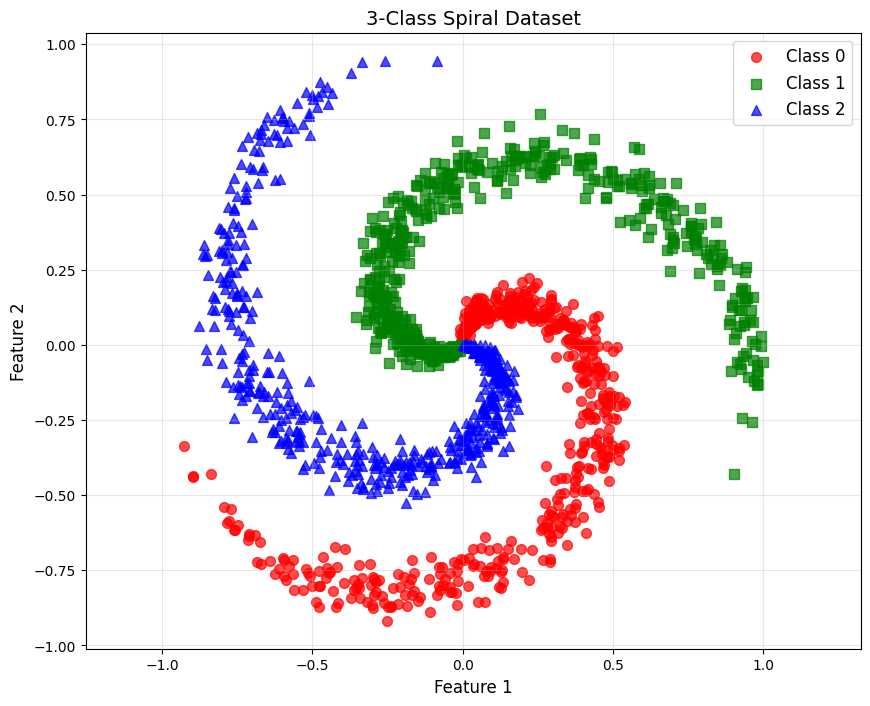

In [6]:
# =============================================================================
# Dataset Creation and Visualization
# =============================================================================

print("=== Creating 3-Class Spiral Dataset ===")

# Create spiral dataset
spiral_dataset = SpiralData(K=3, N=500)  # 3 classes, 500 samples per class
print(f"Dataset created: {len(spiral_dataset)} total samples")  # Display dataset info
print(f"Classes: {spiral_dataset.K}, Samples per class: {spiral_dataset.N}")  # Display class info

# Reshape labels for compatibility
spiral_dataset.y = spiral_dataset.y.view(-1)  # Flatten labels

# Visualize the dataset
print("\nVisualizing spiral dataset...")
spiral_dataset.plot_data()  # Plot the spiral data

=== Experiment 1: Shallow Network (1 Hidden Layer) ===
Network Architecture: 2 -> 50 -> 3
Total layers: 2
Total parameters: 303
  Layer 1: 150 parameters
  Layer 2: 153 parameters

Training Configuration:
  Learning Rate: 0.1
  Batch Size: 20
  Epochs: 100
Training model on cuda for 100 epochs...
  Epoch [20/100], Avg Loss: 0.3442, Accuracy: 0.8627
  Epoch [40/100], Avg Loss: 0.2050, Accuracy: 0.9280
  Epoch [60/100], Avg Loss: 0.1433, Accuracy: 0.9600
  Epoch [80/100], Avg Loss: 0.1070, Accuracy: 0.9807
  Epoch [100/100], Avg Loss: 0.0867, Accuracy: 0.9753


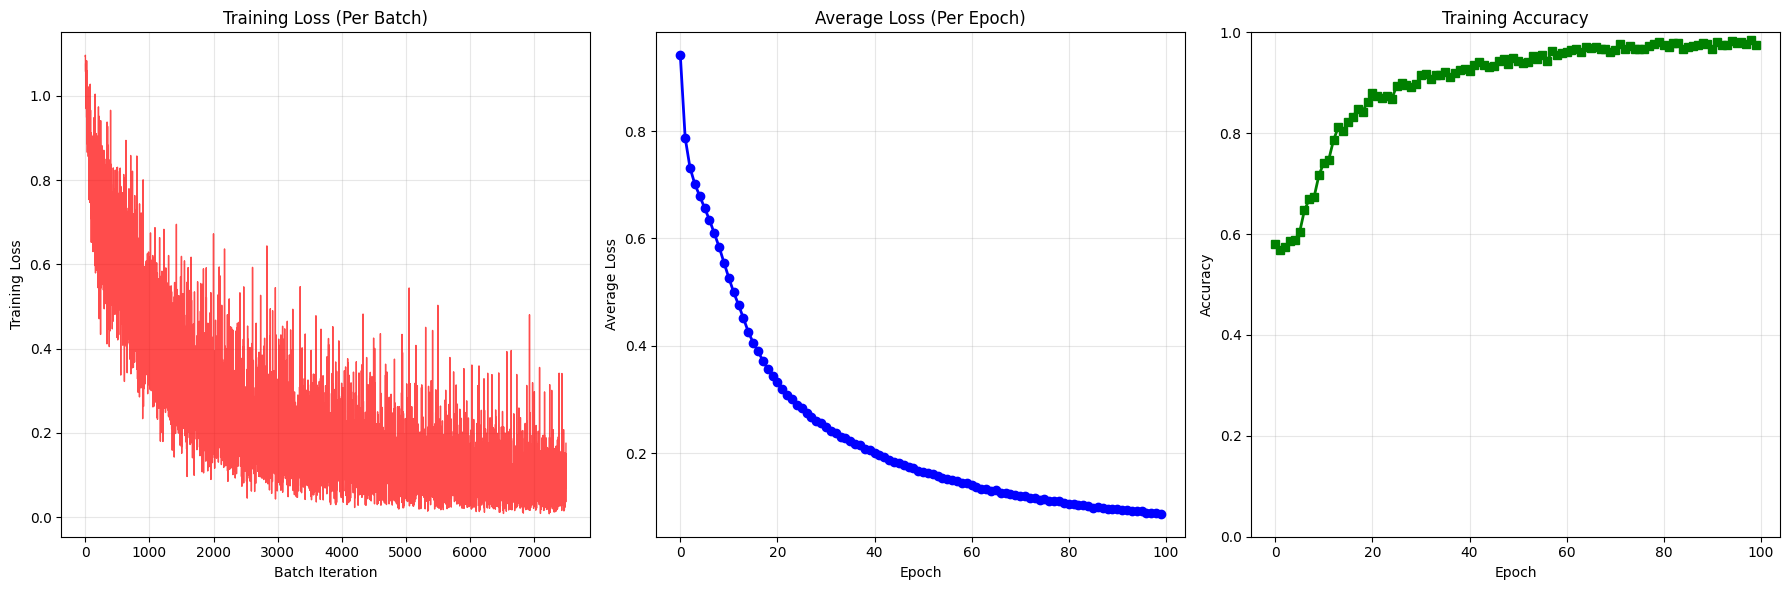


Final accuracy: 0.9753
Plotting decision regions for shallow network...


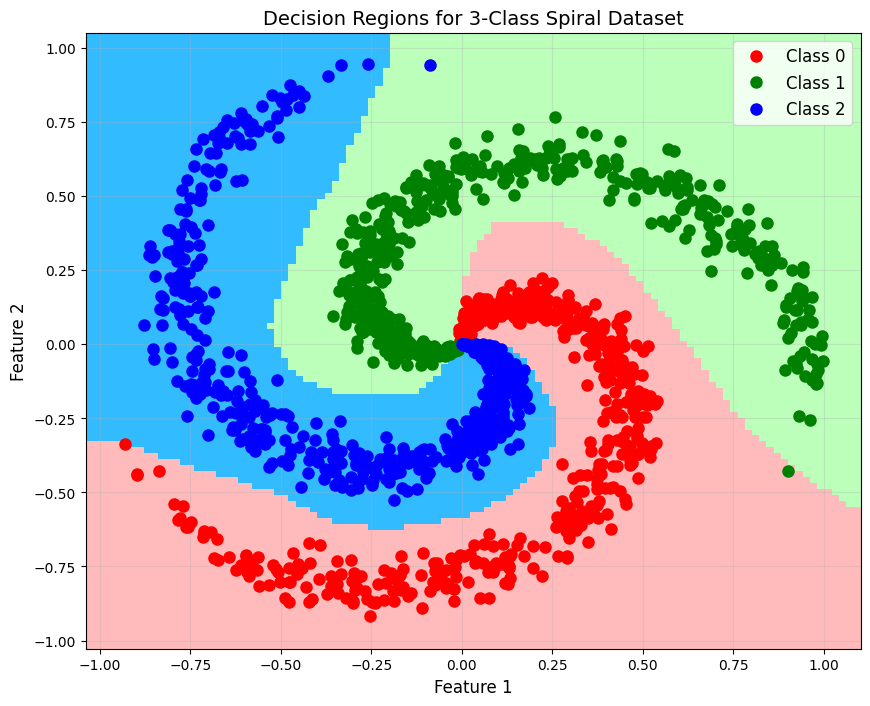

In [7]:
# =============================================================================
# Experiment 1: Shallow Network (1 Hidden Layer with 50 Neurons)
# =============================================================================

print("=== Experiment 1: Shallow Network (1 Hidden Layer) ===")

# Define network architecture
layers_shallow = [2, 50, 3]  # Input: 2D, Hidden: 50 neurons, Output: 3 classes
model_shallow = DeepNetModuleList(layers_shallow)  # Create model
model_shallow.get_architecture_info()  # Display architecture information

# Training configuration
learning_rate = 0.10  # Learning rate for shallow network
batch_size = 20  # Batch size for training
epochs = 100  # Number of training epochs

# Create optimizer and data loader
optimizer_shallow = torch.optim.SGD(model_shallow.parameters(), lr=learning_rate)  # SGD optimizer
train_loader_shallow = DataLoader(dataset=spiral_dataset, batch_size=batch_size, 
                                 shuffle=True, pin_memory=True if device.type == 'cuda' else False)  # Data loader
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

print(f"\nTraining Configuration:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {epochs}")

# Train the shallow model
loss_shallow, acc_shallow, epoch_loss_shallow = train_deep_modulelist(
    spiral_dataset, model_shallow, criterion, train_loader_shallow, optimizer_shallow, epochs
)

# Visualize decision regions
print(f"\nFinal accuracy: {acc_shallow[-1]:.4f}")
print("Plotting decision regions for shallow network...")
plot_decision_regions_3class(model_shallow, spiral_dataset, device)

=== Experiment 2: Medium Deep Network (2 Hidden Layers) ===
Network Architecture: 2 -> 10 -> 10 -> 3
Total layers: 3
Total parameters: 173
  Layer 1: 30 parameters
  Layer 2: 110 parameters
  Layer 3: 33 parameters

Training Configuration:
  Learning Rate: 0.01
  Batch Size: 20
  Epochs: 1000
Training model on cuda for 1000 epochs...
  Epoch [20/1000], Avg Loss: 0.9147, Accuracy: 0.5400
  Epoch [40/1000], Avg Loss: 0.6938, Accuracy: 0.6100
  Epoch [60/1000], Avg Loss: 0.5763, Accuracy: 0.6787
  Epoch [80/1000], Avg Loss: 0.5030, Accuracy: 0.7233
  Epoch [100/1000], Avg Loss: 0.4560, Accuracy: 0.7527
  Epoch [120/1000], Avg Loss: 0.4210, Accuracy: 0.7907
  Epoch [140/1000], Avg Loss: 0.3897, Accuracy: 0.8100
  Epoch [160/1000], Avg Loss: 0.3586, Accuracy: 0.8560
  Epoch [180/1000], Avg Loss: 0.3199, Accuracy: 0.8900
  Epoch [200/1000], Avg Loss: 0.2744, Accuracy: 0.9013
  Epoch [220/1000], Avg Loss: 0.2204, Accuracy: 0.9333
  Epoch [240/1000], Avg Loss: 0.1744, Accuracy: 0.9607
  Epoch 

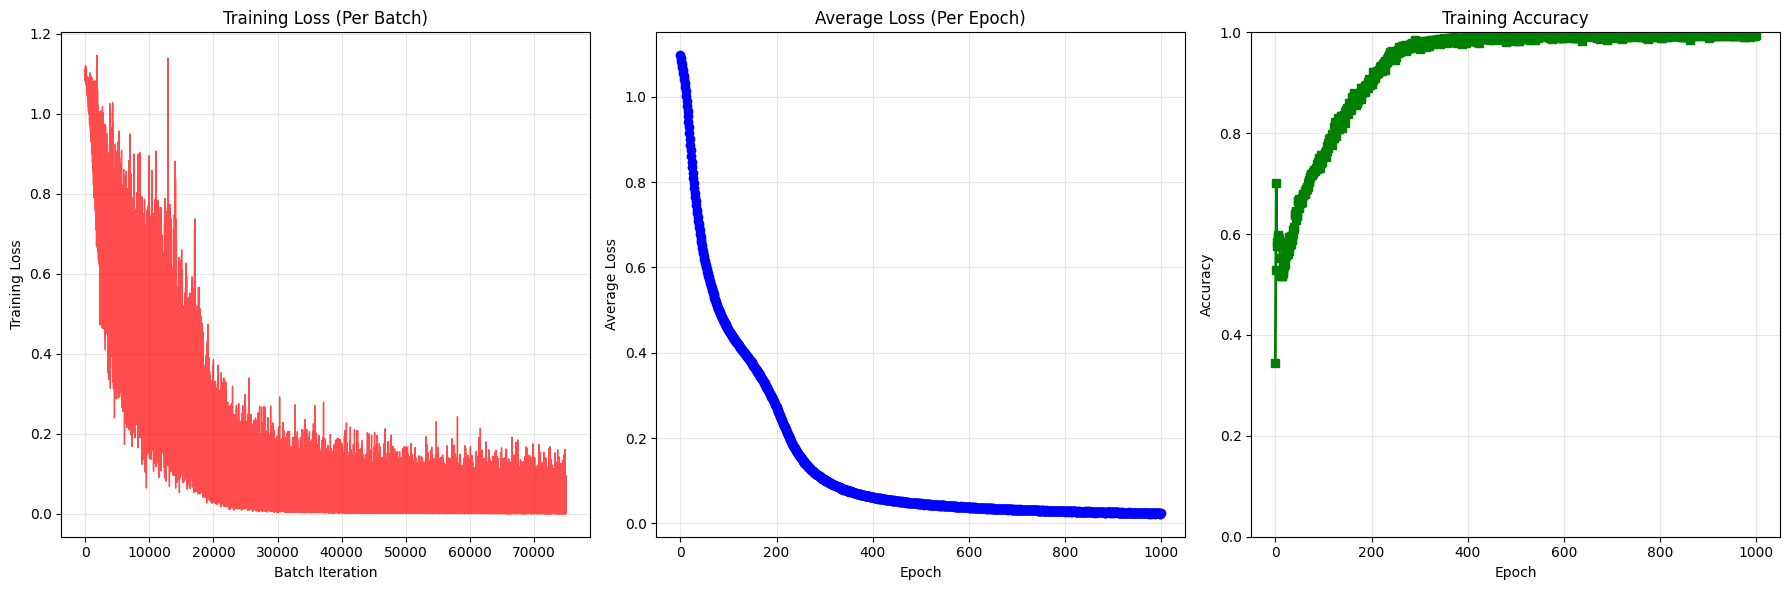


Final accuracy: 0.9947
Plotting decision regions for medium deep network...


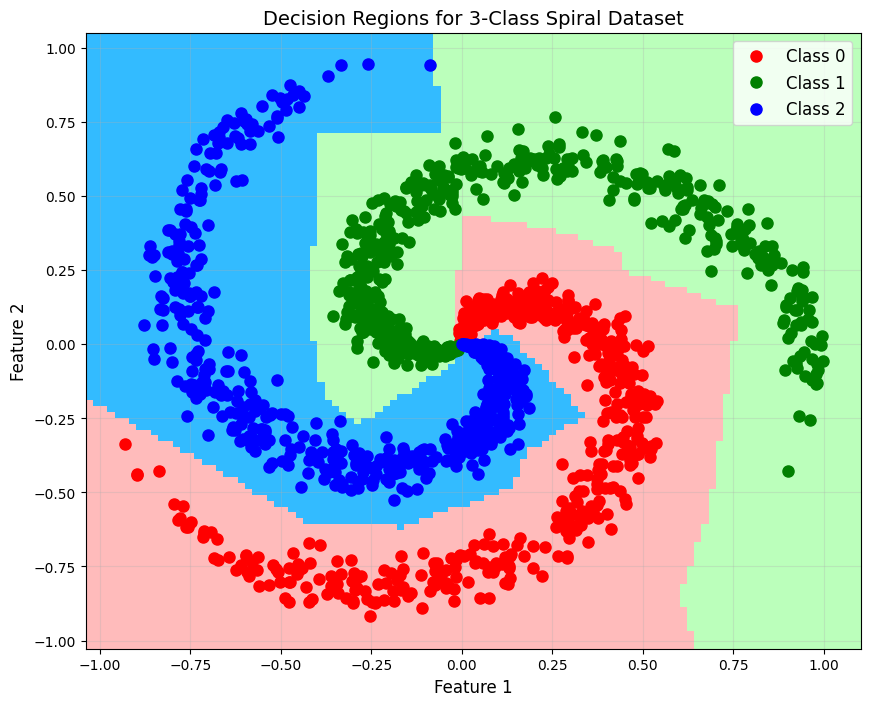

In [8]:
# =============================================================================
# Experiment 2: Medium Deep Network (2 Hidden Layers with 10 Neurons Each)
# =============================================================================

print("=== Experiment 2: Medium Deep Network (2 Hidden Layers) ===")

# Define deeper network architecture
layers_medium = [2, 10, 10, 3]  # Input: 2D, Hidden: 10+10 neurons, Output: 3 classes
model_medium = DeepNetModuleList(layers_medium)  # Create model
model_medium.get_architecture_info()  # Display architecture information

# Training configuration for deeper network
learning_rate_medium = 0.01  # Lower learning rate for stability
epochs_medium = 1000  # More epochs for convergence

# Create optimizer and data loader
optimizer_medium = torch.optim.SGD(model_medium.parameters(), lr=learning_rate_medium)  # SGD optimizer
train_loader_medium = DataLoader(dataset=spiral_dataset, batch_size=batch_size, 
                                shuffle=True, pin_memory=True if device.type == 'cuda' else False)  # Data loader

print(f"\nTraining Configuration:")
print(f"  Learning Rate: {learning_rate_medium}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {epochs_medium}")

# Train the medium deep model
loss_medium, acc_medium, epoch_loss_medium = train_deep_modulelist(
    spiral_dataset, model_medium, criterion, train_loader_medium, optimizer_medium, epochs_medium
)

# Visualize decision regions
print(f"\nFinal accuracy: {acc_medium[-1]:.4f}")
print("Plotting decision regions for medium deep network...")
plot_decision_regions_3class(model_medium, spiral_dataset, device)

=== Experiment 3: Very Deep Network (3 Hidden Layers) ===
Network Architecture: 2 -> 10 -> 10 -> 10 -> 3
Total layers: 4
Total parameters: 283
  Layer 1: 30 parameters
  Layer 2: 110 parameters
  Layer 3: 110 parameters
  Layer 4: 33 parameters

Training Configuration:
  Learning Rate: 0.01
  Batch Size: 20
  Epochs: 1000
Training model on cuda for 1000 epochs...
  Epoch [20/1000], Avg Loss: 1.0442, Accuracy: 0.5220
  Epoch [40/1000], Avg Loss: 0.8510, Accuracy: 0.5613
  Epoch [60/1000], Avg Loss: 0.6379, Accuracy: 0.6327
  Epoch [80/1000], Avg Loss: 0.5110, Accuracy: 0.7567
  Epoch [100/1000], Avg Loss: 0.3426, Accuracy: 0.8680
  Epoch [120/1000], Avg Loss: 0.2068, Accuracy: 0.9373
  Epoch [140/1000], Avg Loss: 0.1408, Accuracy: 0.9520
  Epoch [160/1000], Avg Loss: 0.1103, Accuracy: 0.9753
  Epoch [180/1000], Avg Loss: 0.0861, Accuracy: 0.9707
  Epoch [200/1000], Avg Loss: 0.0766, Accuracy: 0.9753
  Epoch [220/1000], Avg Loss: 0.0676, Accuracy: 0.9793
  Epoch [240/1000], Avg Loss: 0.0

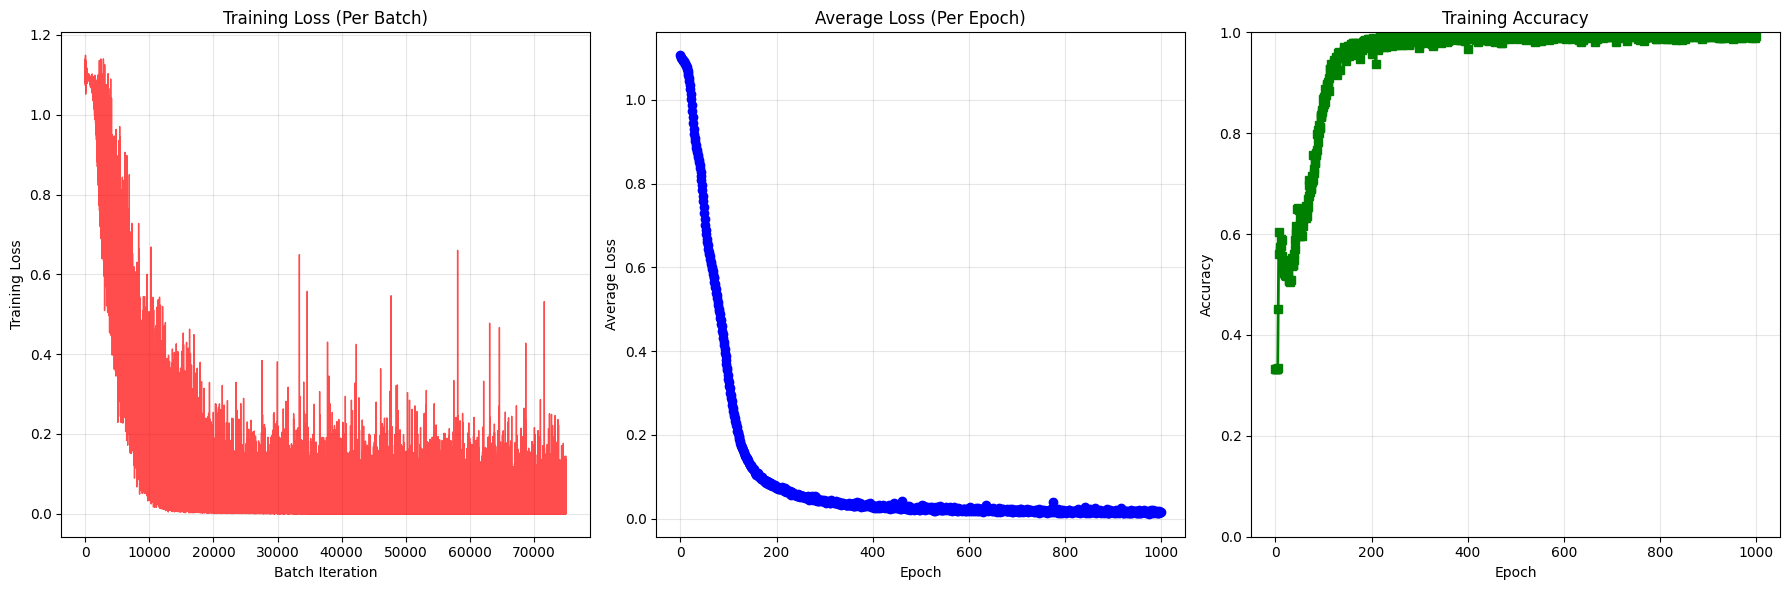


Final accuracy: 0.9927
Plotting decision regions for very deep network...


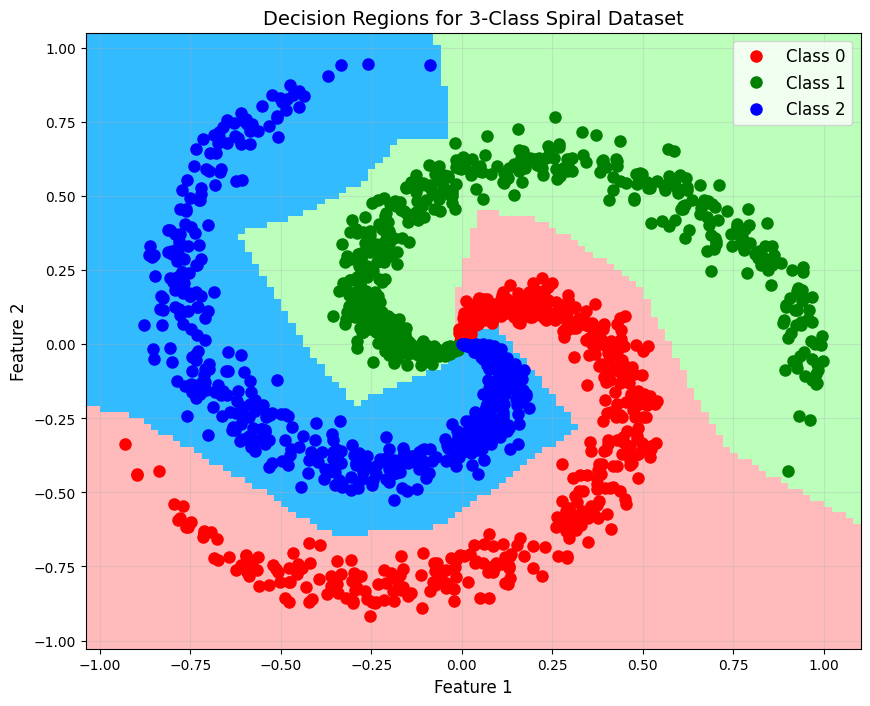

In [9]:
# =============================================================================
# Experiment 3: Very Deep Network (3 Hidden Layers with 10 Neurons Each)
# =============================================================================

print("=== Experiment 3: Very Deep Network (3 Hidden Layers) ===")

# Define very deep network architecture
layers_deep = [2, 10, 10, 10, 3]  # Input: 2D, Hidden: 10+10+10 neurons, Output: 3 classes
model_deep = DeepNetModuleList(layers_deep)  # Create model
model_deep.get_architecture_info()  # Display architecture information

# Training configuration for very deep network
learning_rate_deep = 0.01  # Learning rate for very deep network
epochs_deep = 1000  # Training epochs

# Create optimizer and data loader
optimizer_deep = torch.optim.SGD(model_deep.parameters(), lr=learning_rate_deep)  # SGD optimizer
train_loader_deep = DataLoader(dataset=spiral_dataset, batch_size=batch_size, 
                              shuffle=True, pin_memory=True if device.type == 'cuda' else False)  # Data loader

print(f"\nTraining Configuration:")
print(f"  Learning Rate: {learning_rate_deep}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {epochs_deep}")

# Train the very deep model
loss_deep, acc_deep, epoch_loss_deep = train_deep_modulelist(
    spiral_dataset, model_deep, criterion, train_loader_deep, optimizer_deep, epochs_deep
)

# Visualize decision regions
print(f"\nFinal accuracy: {acc_deep[-1]:.4f}")
print("Plotting decision regions for very deep network...")
plot_decision_regions_3class(model_deep, spiral_dataset, device)

=== Experiment 4: Ultra Deep Network (5 Hidden Layers) ===
Network Architecture: 2 -> 15 -> 12 -> 10 -> 8 -> 6 -> 3
Total layers: 6
Total parameters: 530
  Layer 1: 45 parameters
  Layer 2: 192 parameters
  Layer 3: 130 parameters
  Layer 4: 88 parameters
  Layer 5: 54 parameters
  Layer 6: 21 parameters

Training Configuration:
  Learning Rate: 0.005
  Batch Size: 20
  Epochs: 1500
Training model on cuda for 1500 epochs...
  Epoch [20/1500], Avg Loss: 1.0897, Accuracy: 0.4813
  Epoch [40/1500], Avg Loss: 1.0623, Accuracy: 0.4867
  Epoch [60/1500], Avg Loss: 0.9591, Accuracy: 0.5187
  Epoch [80/1500], Avg Loss: 0.8689, Accuracy: 0.5147
  Epoch [100/1500], Avg Loss: 0.7510, Accuracy: 0.5687
  Epoch [120/1500], Avg Loss: 0.5093, Accuracy: 0.8547
  Epoch [140/1500], Avg Loss: 0.3109, Accuracy: 0.9287
  Epoch [160/1500], Avg Loss: 0.2284, Accuracy: 0.9220
  Epoch [180/1500], Avg Loss: 0.1771, Accuracy: 0.9607
  Epoch [200/1500], Avg Loss: 0.1373, Accuracy: 0.9193
  Epoch [220/1500], Avg Lo

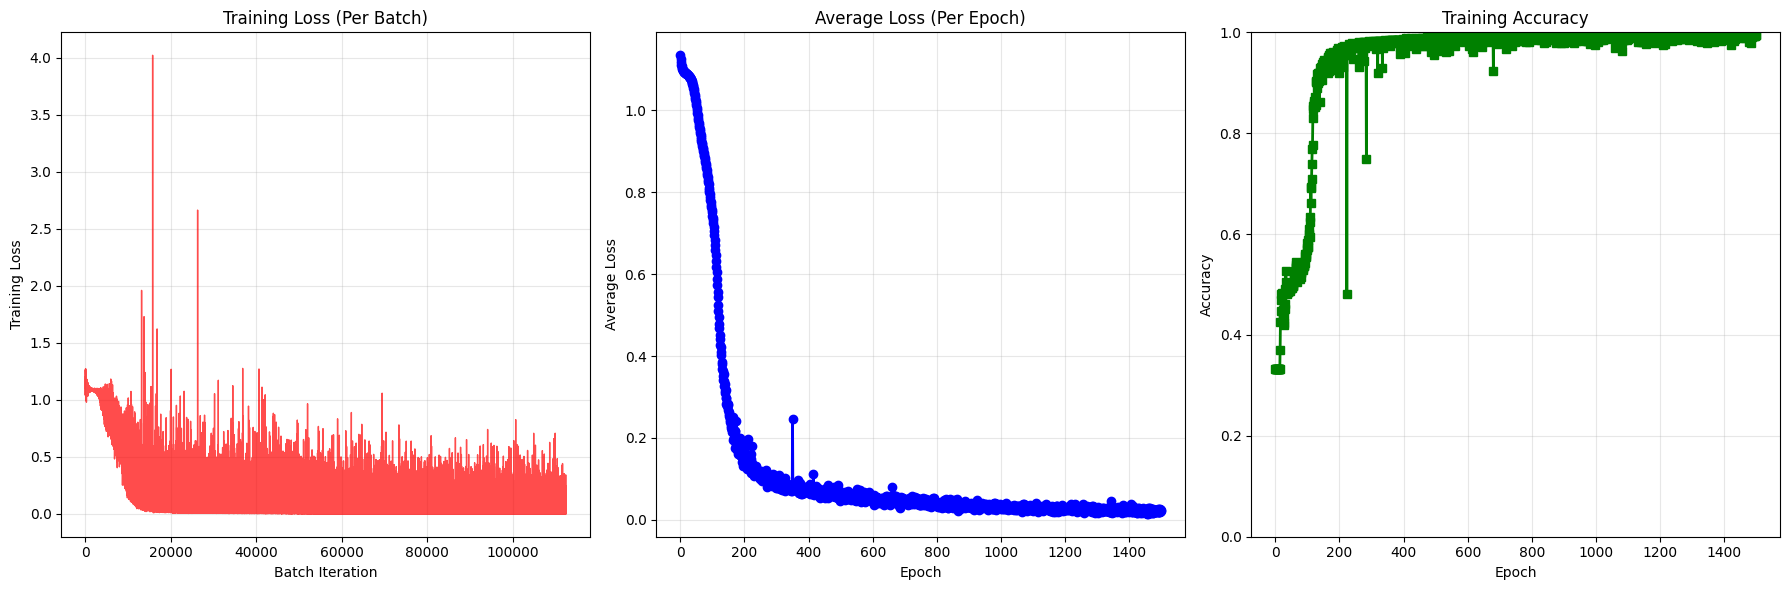


Final accuracy: 0.9940
Plotting decision regions for ultra deep network...


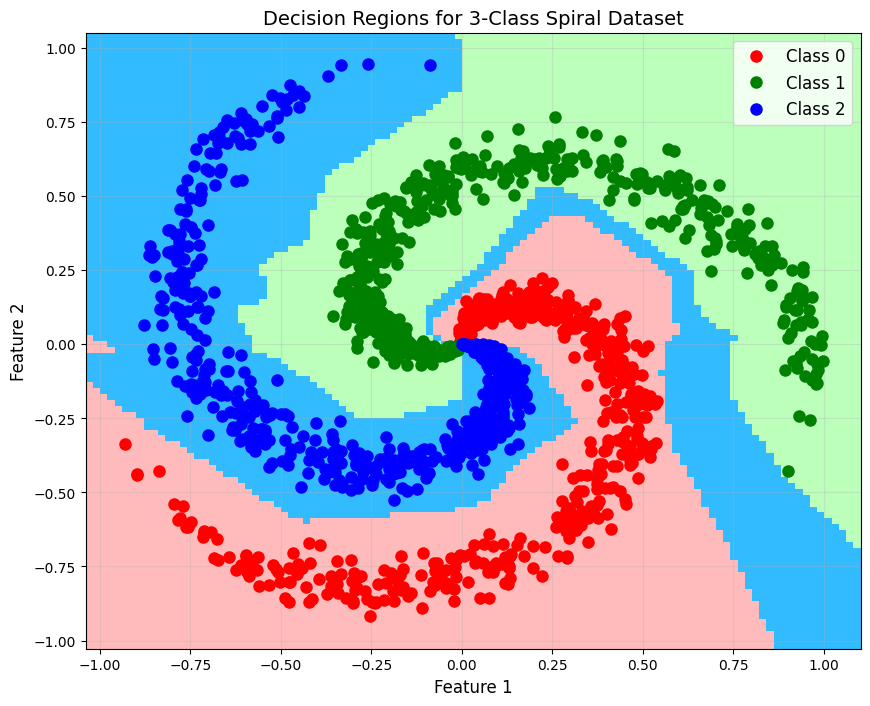

In [10]:
# =============================================================================
# Experiment 4: Ultra Deep Network (5 Hidden Layers)
# =============================================================================

print("=== Experiment 4: Ultra Deep Network (5 Hidden Layers) ===")

# Define ultra deep network architecture
layers_ultra = [2, 15, 12, 10, 8, 6, 3]  # Input: 2D, Hidden layers with decreasing size, Output: 3 classes
model_ultra = DeepNetModuleList(layers_ultra)  # Create model
model_ultra.get_architecture_info()  # Display architecture information

# Training configuration for ultra deep network
learning_rate_ultra = 0.005  # Even lower learning rate
epochs_ultra = 1500  # More epochs for convergence

# Create optimizer and data loader
optimizer_ultra = torch.optim.SGD(model_ultra.parameters(), lr=learning_rate_ultra)  # SGD optimizer
train_loader_ultra = DataLoader(dataset=spiral_dataset, batch_size=batch_size, 
                               shuffle=True, pin_memory=True if device.type == 'cuda' else False)  # Data loader

print(f"\nTraining Configuration:")
print(f"  Learning Rate: {learning_rate_ultra}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {epochs_ultra}")

# Train the ultra deep model
loss_ultra, acc_ultra, epoch_loss_ultra = train_deep_modulelist(
    spiral_dataset, model_ultra, criterion, train_loader_ultra, optimizer_ultra, epochs_ultra
)

# Visualize decision regions
print(f"\nFinal accuracy: {acc_ultra[-1]:.4f}")
print("Plotting decision regions for ultra deep network...")
plot_decision_regions_3class(model_ultra, spiral_dataset, device)


=== Architecture Performance Comparison ===
Architecture         Layers                    Final Accuracy  Parameters
-------------------- ------------------------- --------------- ----------
Shallow (1 Hidden)   2 -> 50 -> 3              0.9753          303
Medium (2 Hidden)    2 -> 10 -> 10 -> 3        0.9947          173
Deep (3 Hidden)      2 -> 10 -> 10 -> 10 -> 3  0.9927          283
Ultra Deep (5 Hidden) 2 -> 15 -> 12 -> 10 -> 8 -> 6 -> 3 0.9940          530


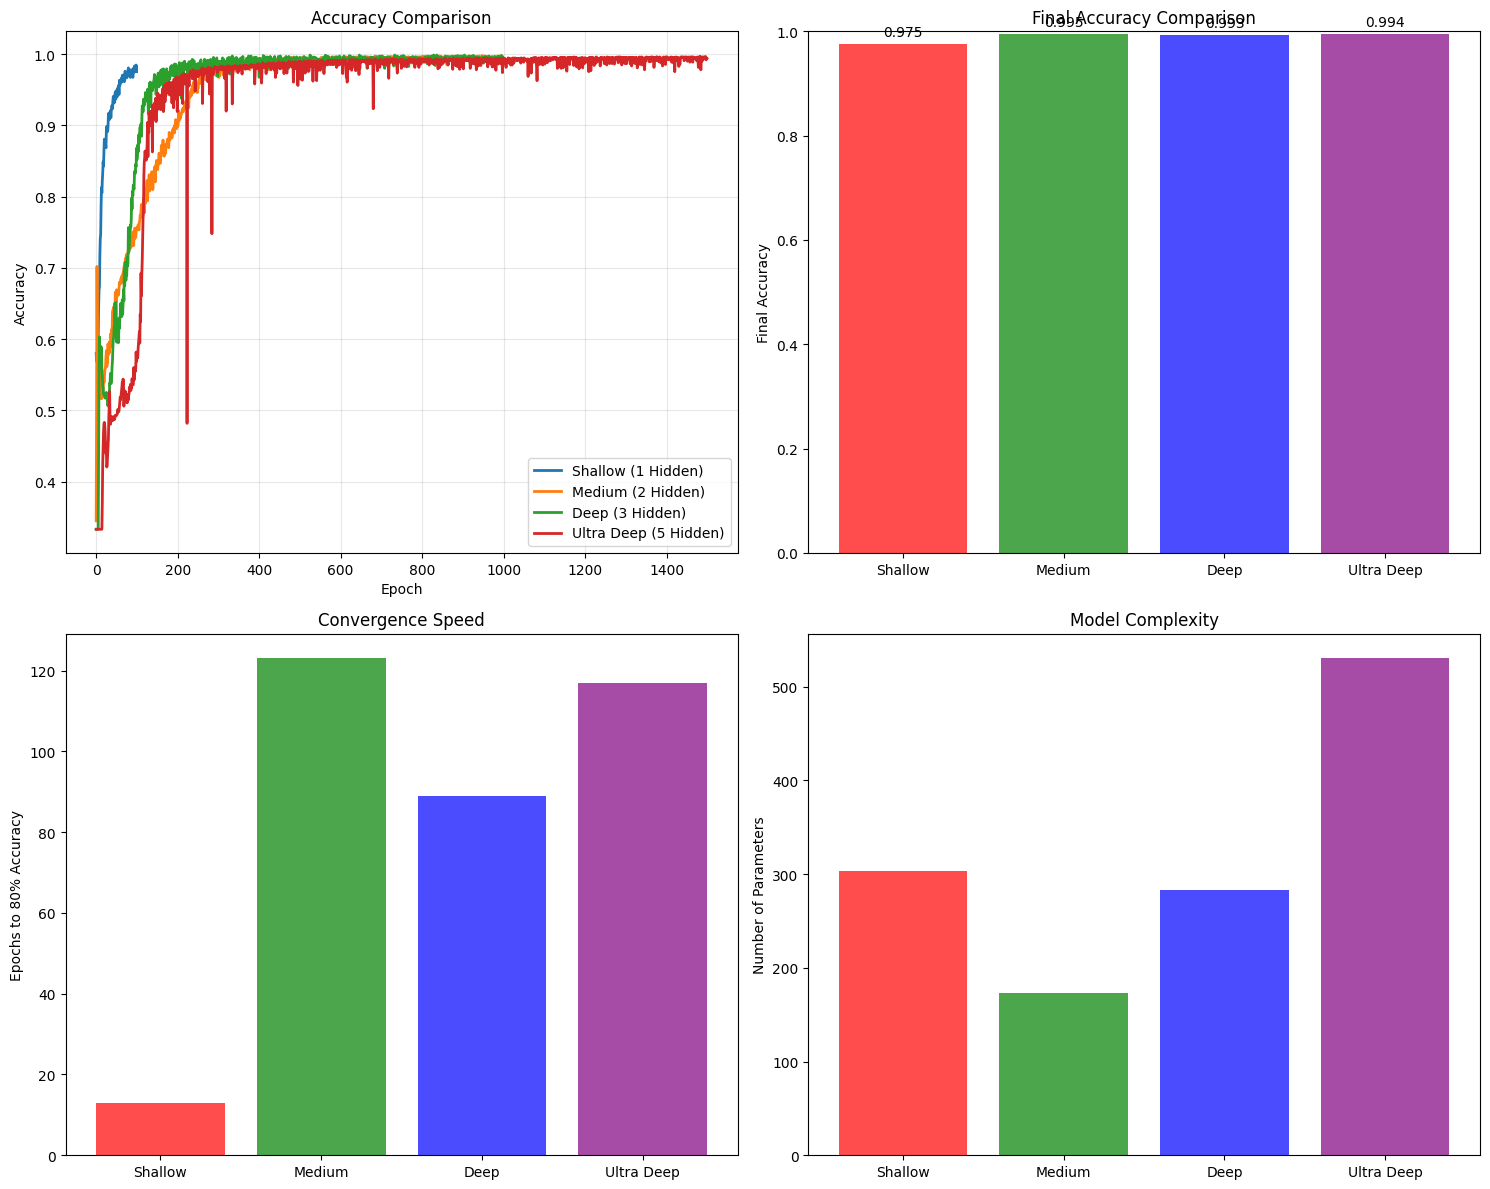

In [11]:
# =============================================================================
# Comprehensive Performance Comparison and Analysis
# =============================================================================

def compare_all_architectures():  # Function to compare all network architectures
    """Compare performance of all trained architectures"""
    
    # Architecture information
    architectures = [
        ("Shallow (1 Hidden)", layers_shallow, acc_shallow[-1]),
        ("Medium (2 Hidden)", layers_medium, acc_medium[-1]),
        ("Deep (3 Hidden)", layers_deep, acc_deep[-1]),
        ("Ultra Deep (5 Hidden)", layers_ultra, acc_ultra[-1])
    ]
    
    print(f"\n=== Architecture Performance Comparison ===")
    print(f"{'Architecture':<20} {'Layers':<25} {'Final Accuracy':<15} {'Parameters'}")
    print(f"{'-'*20} {'-'*25} {'-'*15} {'-'*10}")
    
    for name, layer_config, final_acc in architectures:  # Print comparison table
        layer_str = ' -> '.join(map(str, layer_config))  # Convert layers to string
        
        # Calculate parameters
        temp_model = DeepNetModuleList(layer_config)  # Create temporary model
        total_params = sum(p.numel() for p in temp_model.parameters())  # Count parameters
        
        print(f"{name:<20} {layer_str:<25} {final_acc:<15.4f} {total_params}")
    
    # Plot accuracy comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # Create subplot grid
    
    # Plot accuracy curves
    axes[0, 0].plot(acc_shallow, label='Shallow (1 Hidden)', linewidth=2)  # Shallow accuracy
    axes[0, 0].plot(acc_medium, label='Medium (2 Hidden)', linewidth=2)  # Medium accuracy
    axes[0, 0].plot(acc_deep, label='Deep (3 Hidden)', linewidth=2)  # Deep accuracy
    axes[0, 0].plot(acc_ultra, label='Ultra Deep (5 Hidden)', linewidth=2)  # Ultra deep accuracy
    axes[0, 0].set_xlabel('Epoch')  # X-axis label
    axes[0, 0].set_ylabel('Accuracy')  # Y-axis label
    axes[0, 0].set_title('Accuracy Comparison')  # Title
    axes[0, 0].legend()  # Add legend
    axes[0, 0].grid(True, alpha=0.3)  # Add grid
    
    # Plot final accuracy bar chart
    names = ['Shallow', 'Medium', 'Deep', 'Ultra Deep']  # Architecture names
    final_accuracies = [acc_shallow[-1], acc_medium[-1], acc_deep[-1], acc_ultra[-1]]  # Final accuracies
    colors = ['red', 'green', 'blue', 'purple']  # Colors for bars
    
    bars = axes[0, 1].bar(names, final_accuracies, color=colors, alpha=0.7)  # Bar chart
    axes[0, 1].set_ylabel('Final Accuracy')  # Y-axis label
    axes[0, 1].set_title('Final Accuracy Comparison')  # Title
    axes[0, 1].set_ylim(0, 1)  # Set y-axis limits
    
    # Add value labels on bars
    for bar, acc in zip(bars, final_accuracies):  # Add accuracy labels
        height = bar.get_height()  # Get bar height
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Position text
                       f'{acc:.3f}', ha='center', va='bottom', fontsize=10)  # Format text
    
    # Plot convergence speed (epochs to reach 80% accuracy)
    convergence_threshold = 0.8  # Threshold for convergence
    convergence_epochs = []  # Store convergence epochs
    
    for acc_history in [acc_shallow, acc_medium, acc_deep, acc_ultra]:  # Check convergence
        epoch = next((i for i, acc in enumerate(acc_history) if acc >= convergence_threshold), len(acc_history))
        convergence_epochs.append(epoch)
    
    axes[1, 0].bar(names, convergence_epochs, color=colors, alpha=0.7)  # Convergence bar chart
    axes[1, 0].set_ylabel('Epochs to 80% Accuracy')  # Y-axis label
    axes[1, 0].set_title('Convergence Speed')  # Title
    
    # Plot parameter count comparison
    param_counts = []  # Store parameter counts
    for layer_config in [layers_shallow, layers_medium, layers_deep, layers_ultra]:  # Count parameters
        temp_model = DeepNetModuleList(layer_config)  # Create temporary model
        total_params = sum(p.numel() for p in temp_model.parameters())  # Count parameters
        param_counts.append(total_params)
    
    axes[1, 1].bar(names, param_counts, color=colors, alpha=0.7)  # Parameter count bar chart
    axes[1, 1].set_ylabel('Number of Parameters')  # Y-axis label
    axes[1, 1].set_title('Model Complexity')  # Title
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plots

# Generate comprehensive comparison
compare_all_architectures()

In [12]:
# =============================================================================
# Key Insights and Recommendations
# =============================================================================

print(f"\n=== Key Insights: Deep Networks with nn.ModuleList() ===")

# Find best performing architecture
architectures_names = ['Shallow', 'Medium', 'Deep', 'Ultra Deep']
final_accuracies = [acc_shallow[-1], acc_medium[-1], acc_deep[-1], acc_ultra[-1]]
best_idx = np.argmax(final_accuracies)
best_architecture = architectures_names[best_idx]
best_accuracy = final_accuracies[best_idx]

print(f"\nPerformance Summary:")
print(f"• Best Architecture: {best_architecture} ({best_accuracy:.4f} accuracy)")

print(f"\nAdvantages of nn.ModuleList():")
print(f"• Flexible architecture definition with variable depth")
print(f"• Easy to iterate through layers in forward pass")
print(f"• Automatic parameter registration for optimization")
print(f"• Clean and readable code for deep architectures")

print(f"\nTraining Observations:")
print(f"• Deeper networks required lower learning rates for stability")
print(f"• More epochs needed for deeper networks to converge")
print(f"• Complex spiral dataset benefits from multiple hidden layers")
print(f"• Decision boundaries become more sophisticated with depth")

print(f"\nPractical Recommendations:")
print(f"• Use nn.ModuleList() when network depth is variable or determined dynamically")
print(f"• Start with moderate depth (2-3 hidden layers) before going deeper")
print(f"• Adjust learning rate and epochs based on network depth")
print(f"• Monitor for overfitting with very deep networks on small datasets")
print(f"• Consider batch normalization and dropout for very deep architectures")

print(f"\nGPU Acceleration Benefits:")
if device.type == 'cuda':
    print(f"• All models trained efficiently on GPU: {torch.cuda.get_device_name(0)}")
    print(f"• Batch processing accelerated with CUDA operations")
    print(f"• Larger models can be trained with available GPU memory")
else:
    print(f"• Models trained on CPU - consider GPU for larger architectures")
    print(f"• Deep networks would benefit significantly from GPU acceleration")


=== Key Insights: Deep Networks with nn.ModuleList() ===

Performance Summary:
• Best Architecture: Medium (0.9947 accuracy)

Advantages of nn.ModuleList():
• Flexible architecture definition with variable depth
• Easy to iterate through layers in forward pass
• Automatic parameter registration for optimization
• Clean and readable code for deep architectures

Training Observations:
• Deeper networks required lower learning rates for stability
• More epochs needed for deeper networks to converge
• Complex spiral dataset benefits from multiple hidden layers
• Decision boundaries become more sophisticated with depth

Practical Recommendations:
• Use nn.ModuleList() when network depth is variable or determined dynamically
• Start with moderate depth (2-3 hidden layers) before going deeper
• Adjust learning rate and epochs based on network depth
• Monitor for overfitting with very deep networks on small datasets
• Consider batch normalization and dropout for very deep architectures

GPU A

In [ ]:
# =============================================================================
# Advanced Architecture Exploration (Bonus)
# =============================================================================

def create_custom_architecture(depth, width_pattern='constant'):  # Function to create custom architectures
    """Create custom architecture with specified depth and width pattern"""
    
    if width_pattern == 'constant':  # Constant width
        layers = [2] + [20] * depth + [3]  # Input -> constant hidden -> output
    elif width_pattern == 'decreasing':  # Decreasing width
        hidden_sizes = [max(5, 20 - i*3) for i in range(depth)]  # Decreasing sizes
        layers = [2] + hidden_sizes + [3]  # Input -> decreasing hidden -> output
    elif width_pattern == 'increasing':  # Increasing width
        hidden_sizes = [5 + i*3 for i in range(depth)]  # Increasing sizes
        layers = [2] + hidden_sizes + [3]  # Input -> increasing hidden -> output
    else:  # Pyramid pattern
        mid_point = depth // 2  # Middle layer
        hidden_sizes = []  # Initialize hidden sizes
        for i in range(depth):  # Calculate pyramid sizes
            if i <= mid_point:  # Increasing phase
                size = 5 + i * 5  # Increase size
            else:  # Decreasing phase
                size = 5 + (depth - i - 1) * 5  # Decrease size
            hidden_sizes.append(size)
        layers = [2] + hidden_sizes + [3]  # Input -> pyramid hidden -> output
    
    return layers  # Return layer configuration

# Create and test a pyramid architecture
pyramid_layers = create_custom_architecture(depth=4, width_pattern='pyramid')  # Create pyramid architecture
print(f"\nBonus: Pyramid Architecture Example")
print(f"Architecture: {' -> '.join(map(str, pyramid_layers))}")

pyramid_model = DeepNetModuleList(pyramid_layers)  # Create pyramid model
pyramid_model.get_architecture_info()  # Display architecture info

print(f"\nnn.ModuleList() enables easy experimentation with various architectures!")



Bonus: Pyramid Architecture Example
Architecture: 2 -> 5 -> 10 -> 15 -> 5 -> 3
Network Architecture: 2 -> 5 -> 10 -> 15 -> 5 -> 3
Total layers: 5
Total parameters: 338
  Layer 1: 15 parameters
  Layer 2: 60 parameters
  Layer 3: 165 parameters
  Layer 4: 80 parameters
  Layer 5: 18 parameters

nn.ModuleList() enables easy experimentation with various architectures!
